# Version information

In [1]:
from datetime import date
print("Running date:", date.today().strftime("%B %d, %Y"))
import pyleecan
print("Pyleecan version:" + pyleecan.__version__)
import SciDataTool
print("SciDataTool version:" + SciDataTool.__version__)


Running date: June 05, 2023
Pyleecan version:1.5.1
SciDataTool version:2.5.0


# Force Module을 사용하여 자기력을 계산하는 방법

이 튜토리얼은 pyleecan으로 **자기력을 계산**하는 다양한 단계를 보여줍니다.

SciDataTool 개체의 기능과 사용법을 설명하기 위해 FEMM뮬레이션을 실행하고 전류를 인가하여 실행 시간을 줄이기 위해 주기성과 병렬연산을 사용합니다.

c:\Users\KDH2018-PC\anaconda3\envs\py38_pcan151\lib\site-packages\pyleecan\Methods\Machine\Machine\plot.py:204: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


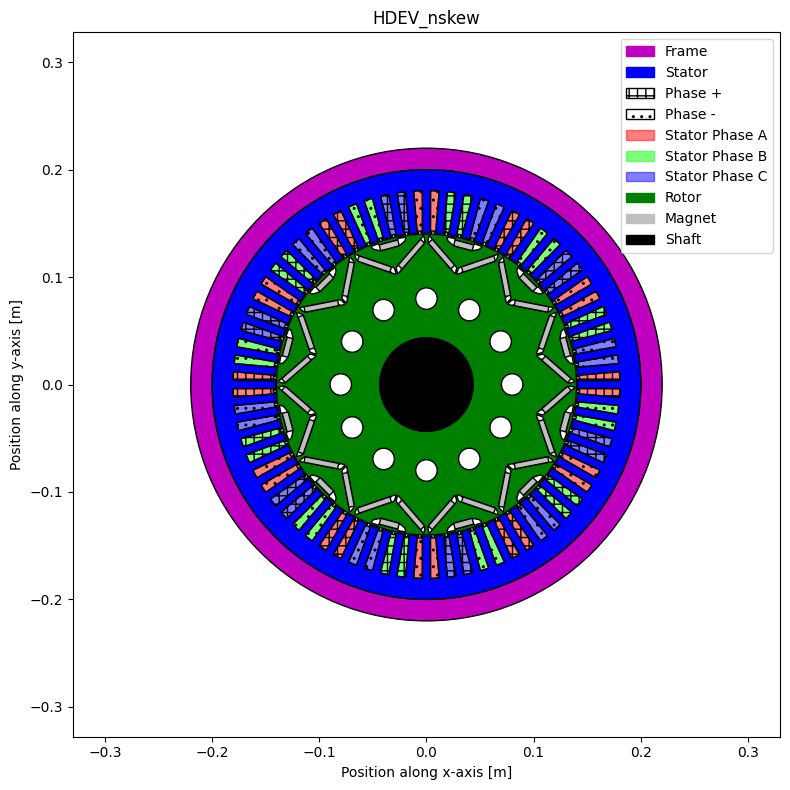

In [4]:
%matplotlib inline

# Load the machine
from os.path import join
from numpy import (
    zeros,
    exp,
    pi,
    real,
    meshgrid,
    mean,
)

# 힘 계산 클래스 추가
from pyleecan.Classes.ForceMT import ForceMT
from pyleecan.Classes.OPdq import OPdq
from pyleecan.Classes.Simu1 import Simu1
from pyleecan.Classes.MagFEMM import MagFEMM
from pyleecan.Classes.InputCurrent import InputCurrent
from pyleecan.definitions import DATA_DIR


from pyleecan.Functions.load import load
from pyleecan.Functions.Plot import dict_2D, dict_3D 

# print(DATA_DIR)
path=r'Z:\Thesis\HDEV\06_Pyleecan'

# path = 'D:/NGV/Lecture_Simu_Model'
modelname = 'HDEV_nskew'
model = join(modelname+'.json')

# Load machine
HDEV12p = load(join(path,model))
HDEV12p.plot()
save_path=path


In [3]:
import numpy as np
from pyleecan.Classes.VarLoadCurrent import VarLoadCurrent
from pyleecan.Classes.ImportMatrixVal import ImportMatrixVal
from pyleecan.Classes.InputCurrent import InputCurrent
from pyleecan.Classes.ImportGenVectLin import ImportGenVectLin
from pyleecan.Classes.ImportGenVectSin import ImportGenVectSin
from pyleecan.Classes.ImportGenMatrixSin import ImportGenMatrixSin
ref_simu = Simu1(name="HDEV12pcurrent_sweep", machine=HDEV12p)



## Simu 1 Simulation (No-load)

In [14]:
from numpy import sqrt, pi
# Definition of the magnetic simulation
# ref_simu.mag = MagFEMM(
#     type_BH_stator=0,
#     type_BH_rotor=0,
#     is_periodicity_a=True,
#     is_periodicity_t=True,
#     Kgeo_fineness=1,
#     Kmesh_fineness=2,
#     nb_worker=8,
# )
ref_simu.mag = MagFEMM(
    type_BH_stator=0,
    type_BH_rotor=0,
    is_periodicity_a=True,
    is_periodicity_t=True,
    Kgeo_fineness=0.2,
    Kmesh_fineness=0.2,
    nb_worker=8,
)
ref_simu.force=ForceMT(  is_periodicity_a=True,is_periodicity_t=True)




ref_simu.input = InputCurrent()
# ref_simu.input.Nt_tot = 720 # Number of time step
ref_simu.input.Nt_tot = 120 # Number of time step
ref_simu.input.Na_tot = 2520 # Spatial discretization
# Set reference simulation operating point
ref_simu.input.OP = OPdq(N0 = 1000) # Rotor speed [rpm]
ref_simu.input.OP.Tem_av_ref = 353
ref_simu.input.OP.set_I0_Phi0(I0=250/sqrt(2), Phi0=140*pi/180)



In [23]:
ref_simu.mag.T_mag=20
Tmag100_simu=ref_simu.copy()

In [24]:
Tmag100_simu.mag.T_mag=100
ref_simu.mag.T_mag

20

In [28]:
output_Tmag100=Tmag100_simu.run()
output_ref=ref_simu.run()

[22:46:44] Starting running simulation HDEV12pcurrent_sweep (machine=HDEV_nskew)
[22:46:44] Starting Magnetic module
[22:46:47] Computing Airgap Flux in FEMM
[22:46:59] Starting Force module
[22:46:59] End of simulation HDEV12pcurrent_sweep


c:\Users\KDH2018-PC\anaconda3\envs\py38_pcan151\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:539: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


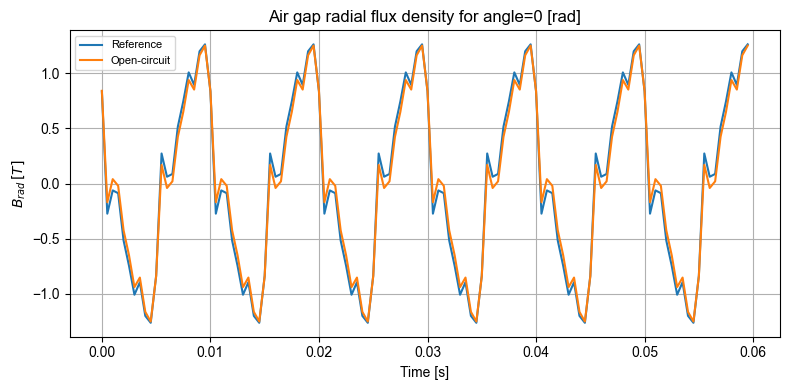

In [29]:
output_ref.mag.B.plot_2D_Data(
    "time", component_list=["radial"], data_list=[output_Tmag100.mag.B], legend_list=["Reference", "Open-circuit"]
)

Main torque Output:
Average Electromagnetic torque [N.m]:406.4030566002815
Peak to Peak Torque ripple [N.m]:97.4102919208176
Peak to Peak Torque ripple normalized according to average torque [-]:0.23968887620012583
Torque values (with symmetry):
[397.15858324 399.6672193  402.87700293 413.116141   374.61457435
 441.06604666 442.60815434 345.19786242 415.41022827 432.31475351]

Operating Point:
Rotor speed [rpm]:1000
Id [Arms]:-135.4188051049254
Iq [Arms]:113.62986941801093


c:\Users\KDH2018-PC\anaconda3\envs\py38_pcan151\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:539: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
c:\Users\KDH2018-PC\anaconda3\envs\py38_pcan151\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:539: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


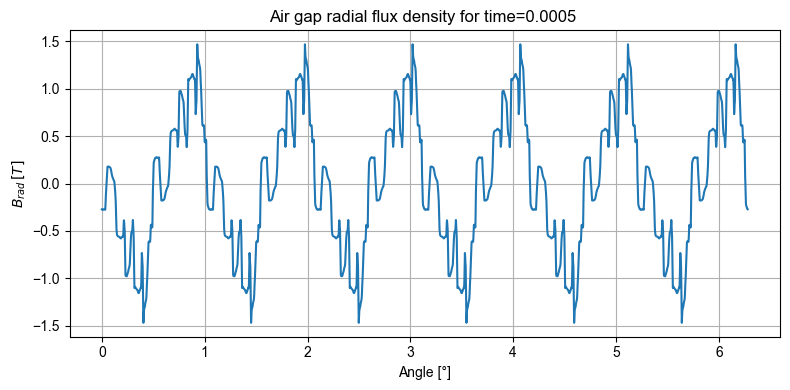

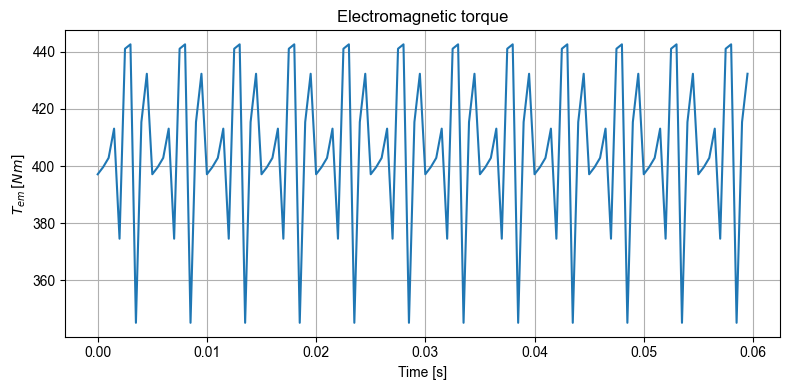

In [30]:
# output_ref = ref_simu.run()
# Flux
output_ref.mag.B.plot_2D_Data("angle","time[1]",component_list=["radial"])

# Torque
output_ref.mag.Tem.plot_2D_Data("time")
print("Main torque Output:")
print("Average Electromagnetic torque [N.m]:" +str(output_ref.mag.Tem_av))
print("Peak to Peak Torque ripple [N.m]:" +str(output_ref.mag.Tem_rip_pp))
print("Peak to Peak Torque ripple normalized according to average torque [-]:" +str(output_ref.mag.Tem_rip_norm))
print("Torque values (with symmetry):\n"+str(output_ref.mag.Tem.values))

# Operating point
print("\nOperating Point:")
print("Rotor speed [rpm]:"+str(output_ref.elec.OP.N0))
print("Id [Arms]:"+str(output_ref.elec.OP.Id_ref))
print("Iq [Arms]:"+str(output_ref.elec.OP.Iq_ref))

## OP_Matrix  작성 VarloadCurrent>VarLoad(OP_matrix)>VarSimu

In [32]:
from pyleecan.Classes.VarLoadCurrent import VarLoadCurrent
from numpy import zeros, ones, linspace, array, sqrt, arange

# Definition of the enforced output of the electrical module
# Is_mat = zeros((1, 3))
# Is_mat[0, :] = np.array([0, 12.2474, -12.2474])
# Is = ImportMatrixVal(value=Is_mat)
# time = ImportGenVectLin(start=0, stop=0, num=1, endpoint=False)
# Na_tot = 2048
# simu_vop = ref_simu.copy()
# simu_vop.mag.import_file = None
# varload = VarLoadCurrent()
# simu_vop.var_simu = varload
# N_speed=50


# Build OP_matrix with a meshgrid of Id/Iq
n_Id=6
n_Iq=6
# Id_min, Id_max = -750, 750
# Iq_min, Iq_max = -750, 750
Id_min, Id_max = -750, 0
Iq_min, Iq_max = 0, 750
Id, Iq = np.meshgrid(
np.linspace(Id_min, Id_max, n_Id),np.linspace(Iq_min, Iq_max, n_Iq)
)
# Id Iq type
OP_matrix = np.zeros((n_Id * n_Iq, 3))
OP_matrix[:, 0] = ref_simu.input.OP.N0
OP_matrix[:, 1] = Id.ravel()/np.sqrt(2) #ravel() 다차원 배열 1차원 변환 함수
OP_matrix[:, 2] = Iq.ravel()/np.sqrt(2)
# type(OP_matrix)

# Ipk phase type
# Creating the Operating point matrix
# OP_matrix = zeros((N_speed,4))
# # Set N0 = 2000 [rpm] for all simulation
# OP_matrix[:,0] = 2000 * ones((N_speed))
# # Set I0 = 250 / sqrt(2) [A] (RMS) for all simulation
# OP_matrix[:,1] = 250/sqrt(2) * ones((N_speed)) 
# Set Phi0 from 60° to 180°
# OP_matrix[:,2] = Phi0_ref
# Set reference torque from Yang et al, 2013
# OP_matrix[:,3] = Tem_av_ref

varload = VarLoadCurrent()
varload.OP_matrix = OP_matrix
varload.is_reuse_femm_file=True  

### Simu1에 varload 할당

In [33]:
from pyleecan.Classes.VarSimu import VarSimu
simu_vop = ref_simu.copy()
simu_vop.var_simu = varload
simu_vop.var_simu.is_keep_all_output = True

In [47]:
Xout_vop = simu_vop.run()


[18:16:09] Starting running simulation HDEV12pcurrent_sweep (machine=HDEV_nskew)
[18:16:09] Reference Operating point is not in OP_matrix, one extra simulation will be computed
[18:16:09] Computing reference simulation for Variable Load
[18:16:09] Starting Magnetic module
[18:16:12] Computing Airgap Flux in FEMM
[18:16:29] Starting Force module
[18:16:29] Variable Load Reference Results: N0=1000 [rpm], Id=-135.4 [Arms], Iq=113.6 [Arms], Tem_av=406.4 [N.m], Tem_rip_pp=97.41 [N.m], Tem_rip_norm=0.2397 [-], Pem_av=4.256e+04 [W]
[=                                                 ]   2%
[18:16:29] Variable Load: Using same FEMM file for all simulations (C:\Users\KDH2018-PC\anaconda3\envs\py38_pcan151\Lib\site-packages\pyleecan\Results\HDEV12pcurrent_sweep\Femm\HDEV_nskew_model.fem)
[18:16:29] Running simulation 1/36 with N0=1000 [rpm], Id=-530.3 [Arms], Iq=0 [Arms]
[18:16:29] Starting Magnetic module
[18:16:30] Computing Airgap Flux in FEMM
[18:16:50] Starting Force module
[18:16:50] Variab

### output] Xout_vop Export to Mat

In [86]:
import os
from datetime import datetime
import scipy.io as sio


force_r_r0_0fs = []
force_r_r0_6fs = []
force_r_r0_12fs = []
force_r_r24_6fs = []
force_t_r0_0fs = []
force_t_r0_6fs = []
force_t_r0_12fs = []
force_t_r24_6fs = []

Torque_map = []

output_folder = r'Z:\Thesis\HDEV\06_Pyleecan'
extension = '.mat'



for i in range(0, len(Xout_vop.output_list)):
    
    Torque_map = np.append(Torque_map, Xout_vop.output_list[i].mag.Tem_av)
    # Total Mat
    filename_prefix = datetime.now().strftime("%Y%m%d_%H") + '_op_case'
    filename = '{}{}{}'.format(filename_prefix, i, extension)
    filepath = os.path.join(output_folder, filename)
    Xout_vop.output_list[i].export_to_mat(filepath)
    # Force Mat
    force_r_r0_0fs = np.append(force_r_r0_0fs, Xout_vop.output_list[i].force.AGSF.components['radial'].get_magnitude_along('freqs->elec_order=0', 'wavenumber=0')['AGSF_r'])
    force_r_r0_6fs = np.append(force_r_r0_6fs, Xout_vop.output_list[i].force.AGSF.components['radial'].get_magnitude_along('freqs->elec_order=6', 'wavenumber=0')['AGSF_r'])
    force_r_r0_12fs = np.append(force_r_r0_12fs, Xout_vop.output_list[i].force.AGSF.components['radial'].get_magnitude_along('freqs->elec_order=12', 'wavenumber=0')['AGSF_r'])
    force_r_r24_6fs = np.append(force_r_r24_6fs, Xout_vop.output_list[i].force.AGSF.components['radial'].get_magnitude_along('freqs->elec_order=6', 'wavenumber=24')['AGSF_r'])
    
    force_t_r0_0fs = np.append(force_t_r0_0fs, Xout_vop.output_list[i].force.AGSF.components['tangential'].get_magnitude_along('freqs->elec_order=0', 'wavenumber=0')['AGSF_t'])
    force_t_r0_6fs = np.append(force_t_r0_6fs, Xout_vop.output_list[i].force.AGSF.components['tangential'].get_magnitude_along('freqs->elec_order=6', 'wavenumber=0')['AGSF_t'])
    force_t_r0_12fs = np.append(force_t_r0_12fs, Xout_vop.output_list[i].force.AGSF.components['tangential'].get_magnitude_along('freqs->elec_order=12', 'wavenumber=0')['AGSF_t'])
    force_t_r24_6fs = np.append(force_t_r24_6fs, Xout_vop.output_list[i].force.AGSF.components['tangential'].get_magnitude_along('freqs->elec_order=6', 'wavenumber=24')['AGSF_t'])
    
        # Create a dictionary to store the variables
    Force2DFFTMap = {
        'force_r_r0_0fs': force_r_r0_0fs[i],
        'force_r_r0_6fs': force_r_r0_6fs[i],
        'force_r_r0_12fs': force_r_r0_12fs[i],
        'force_r_r24_6fs': force_r_r24_6fs[i],
        'force_t_r0_0fs': force_t_r0_0fs[i],
        'force_t_r0_6fs': force_t_r0_6fs[i],
        'force_t_r0_12fs': force_t_r0_12fs[i],
        'force_t_r24_6fs': force_t_r24_6fs[i]
    }
    
    # Save the variables to a mat file
    filename = '{}{}{}{}'.format(filename_prefix, i,'Force', extension)
    filepath = os.path.join(output_folder, filename)
    sio.savemat(filepath, Force2DFFTMap)
    
  

In [38]:
simu_vopTmag100=simu_vop.copy()
simu_vopTmag100.mag.T_mag=100
Xout_vopTmag100 = simu_vopTmag100.run()



force_r_r0_0fs = []
force_r_r0_6fs = []
force_r_r0_12fs = []
force_r_r24_6fs = []
force_t_r0_0fs = []
force_t_r0_6fs = []
force_t_r0_12fs = []
force_t_r24_6fs = []

Torque_map = []

output_folder = r'Z:\Thesis\HDEV\06_Pyleecan'
extension = '.mat'



for i in range(0, len(Xout_vopTmag100.output_list)):
    
    Torque_map = np.append(Torque_map, Xout_vopTmag100.output_list[i].mag.Tem_av)
    # Total Mat
    filename_prefix = datetime.now().strftime("%Y%m%d_%H") + '_Tmag100op_case'
    filename = '{}{}{}'.format(filename_prefix, i, extension)
    filepath = os.path.join(output_folder, filename)
    Xout_vopTmag100.output_list[i].export_to_mat(filepath)
    # Force Mat
    force_r_r0_0fs = np.append(force_r_r0_0fs, Xout_vopTmag100.output_list[i].force.AGSF.components['radial'].get_magnitude_along('freqs->elec_order=0', 'wavenumber=0')['AGSF_r'])
    force_r_r0_6fs = np.append(force_r_r0_6fs, Xout_vopTmag100.output_list[i].force.AGSF.components['radial'].get_magnitude_along('freqs->elec_order=6', 'wavenumber=0')['AGSF_r'])
    force_r_r0_12fs = np.append(force_r_r0_12fs, Xout_vopTmag100.output_list[i].force.AGSF.components['radial'].get_magnitude_along('freqs->elec_order=12', 'wavenumber=0')['AGSF_r'])
    force_r_r24_6fs = np.append(force_r_r24_6fs, Xout_vopTmag100.output_list[i].force.AGSF.components['radial'].get_magnitude_along('freqs->elec_order=6', 'wavenumber=24')['AGSF_r'])
    
    force_t_r0_0fs = np.append(force_t_r0_0fs, Xout_vopTmag100.output_list[i].force.AGSF.components['tangential'].get_magnitude_along('freqs->elec_order=0', 'wavenumber=0')['AGSF_t'])
    force_t_r0_6fs = np.append(force_t_r0_6fs, Xout_vopTmag100.output_list[i].force.AGSF.components['tangential'].get_magnitude_along('freqs->elec_order=6', 'wavenumber=0')['AGSF_t'])
    force_t_r0_12fs = np.append(force_t_r0_12fs, Xout_vopTmag100.output_list[i].force.AGSF.components['tangential'].get_magnitude_along('freqs->elec_order=12', 'wavenumber=0')['AGSF_t'])
    force_t_r24_6fs = np.append(force_t_r24_6fs, Xout_vopTmag100.output_list[i].force.AGSF.components['tangential'].get_magnitude_along('freqs->elec_order=6', 'wavenumber=24')['AGSF_t'])
    
        # Create a dictionary to store the variables
    Force2DFFTMap = {
        'force_r_r0_0fs': force_r_r0_0fs[i],
        'force_r_r0_6fs': force_r_r0_6fs[i],
        'force_r_r0_12fs': force_r_r0_12fs[i],
        'force_r_r24_6fs': force_r_r24_6fs[i],
        'force_t_r0_0fs': force_t_r0_0fs[i],
        'force_t_r0_6fs': force_t_r0_6fs[i],
        'force_t_r0_12fs': force_t_r0_12fs[i],
        'force_t_r24_6fs': force_t_r24_6fs[i]
    }
    
    # Save the variables to a mat file
    filename = '{}{}{}{}'.format(filename_prefix, i,'Force', extension)
    filepath = os.path.join(output_folder, filename)
    sio.savemat(filepath, Force2DFFTMap)

[23:10:04] Starting running simulation HDEV12pcurrent_sweep (machine=HDEV_nskew)
[23:10:04] Reference Operating point is not in OP_matrix, one extra simulation will be computed
[23:10:04] Computing reference simulation for Variable Load
[23:10:04] Starting Magnetic module
[23:10:06] Computing Airgap Flux in FEMM
[23:10:18] Starting Force module
[23:10:18] Variable Load Reference Results: N0=1000 [rpm], Id=-135.4 [Arms], Iq=113.6 [Arms], Tem_av=392.6 [N.m], Tem_rip_pp=88.77 [N.m], Tem_rip_norm=0.2261 [-], Pem_av=4.112e+04 [W]
[=                                                 ]   2%
[23:10:18] Variable Load: Using same FEMM file for all simulations (C:\Users\KDH2018-PC\anaconda3\envs\py38_pcan151\Lib\site-packages\pyleecan\Results\HDEV12pcurrent_sweep\Femm\HDEV_nskew_model.fem)
[23:10:18] Running simulation 1/36 with N0=1000 [rpm], Id=-530.3 [Arms], Iq=0 [Arms]
[23:10:18] Starting Magnetic module
[23:10:18] Computing Airgap Flux in FEMM
[23:10:34] Starting Force module
[23:10:34] Variab

KeyboardInterrupt: 